In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from names import particleLabels
from sparticleNames import SParticleNames
import pandas as pd
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))
from smodels.tools import smodelsLogging
smodelsLogging.setLogLevel('error')

In [2]:
#Set colors:
allPids = [1000022, 1000006, 1000001, 1000021, 1000012, 1000023, 
            1000013, 2000006, 1000011, 1000005, 1000014, 1000004, 1000015, 1000016, 1000024]
namer = SParticleNames ( susy = False )
colors = sns.color_palette('deep',n_colors=len(namer.xIDs))

#Replace default colors:
for pid in sorted(namer.xIDs.keys()):
    if not pid in allPids:
        allPids.append(pid)
colorDict = dict(zip(allPids,colors))
colorDict[1000002] = colorDict[1000001]
colorDict[1000003] = colorDict[1000001]
colorDict[1000004] = colorDict[1000001]

In [3]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict

def getPredictions(protomodel,dbpath):
    
    #Compute predictions:
    pred = Predictor(walkerid=0,dbpath=dbpath)
    res = pred.predict(protomodel)

In [4]:
modelList = []
m = Manipulator("")
with open('../toyWalk/results/history0.list') as f:
    data = f.read()
    #Fix history format
    data = data[data.find('['):data.rfind('#')] #Remove comment line
    data = data.replace('\n','')
    if data[-1] == ',':
        data = data[:-1] + ']'
        
#Get list of dictionaries and restore protomodels
pList = eval(data)
for D in pList:
    protomodel = ProtoModel(dbversion='toy-database')
    protomodel.templateSLHA = '../builder/templates/template1g.slha'
    #Set attributes to dictionary values:
    for k,v in D["masses"].items():
        protomodel.masses[k]=v
    for k,v in D["ssmultipliers"].items():
        protomodel.ssmultipliers[k]=v
    for mpid,decays in D["decays"].items():        
        if not mpid in protomodel.decays:        
            protomodel.decays[mpid]={}
        for dpid,v in decays.items():
            protomodel.decays[mpid][dpid]=v
    if "step" in D: ## keep track of number of steps
        protomodel.step = D["step"]-1
    if "Z" in D:
        protomodel.Z = D["Z"]
    if "K" in D:
        protomodel.K = D["K"]
    modelList.append(protomodel)        
   
modelList = sorted(modelList, key = lambda p: p.step)        

In [5]:
#Get all particles which appears in all steps:
particles = []
for p in modelList:
    particles += p.unFrozenParticles()
particles = list(set(particles))

In [6]:
#Build useful dataset:
steps = np.array([p.step for p in modelList])
nparticles = np.array([len(p.unFrozenParticles()) for p in modelList])
Kvalues = np.array([p.K if (p.K and p.K > 0) else 0.0 for p in modelList])
Zvalues = np.array([p.Z if (p.Z and p.Z > 0) else 0.0 for p in modelList])
masses = dict([[pid,[]] for pid in particles])
for p in modelList:
    for pid in masses:
        if pid in p.masses:
            masses[pid].append(p.masses[pid])
        else:
            masses[pid].append(-100.0)
for pid in masses:
    masses[pid] = np.array(masses[pid])
dataDict = {'step' : steps, 'K' : Kvalues, 'Z' : Zvalues, 
                   'nparticles' : nparticles}
dataDict.update(masses) 
df = pd.DataFrame(dataDict)

In [7]:
print('Max K = %1.2f at step %i' %(Kvalues[np.argmax(Kvalues)],np.argmax(Kvalues)))
print(modelList[np.argmax(Kvalues)])

Max K = 3.65 at step 94
ProtoModel (XZ1,Xt): K = 3.65, Z = 2.43


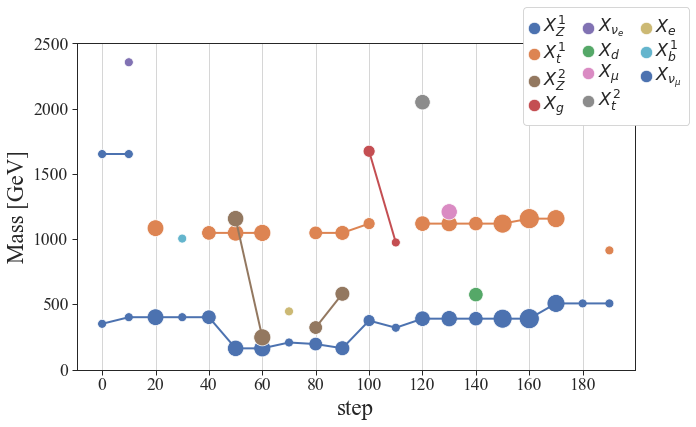

In [8]:
fig = plt.figure(figsize=(10, 6))
nsteps = 10

pids = sorted(masses.keys(), key = lambda pid: np.sum(np.where(masses[pid][::nsteps] <= 0)))
for pid in pids:
    if max(masses[pid][::nsteps]) <= 0.0: continue
    data = df[::nsteps]
    sns.scatterplot(x=data['step'],y=data[pid], size=data['K'], sizes = (80,400),
                    label=r'$%s$' %(particleLabels[pid]), legend=False, 
                    color=[colorDict[pid]])
    m = np.where(masses[pid] > 0, masses[pid],np.nan) #Fix for avoid plotting to negative values
    plt.plot(df['step'][::nsteps],m[::nsteps],'-',linewidth=2,color=colorDict[pid])

plt.ylim(0.,2500.0)
plt.xlabel('step', fontsize=23)
plt.ylabel('Mass [GeV]', fontsize=23)
plt.xticks(df['step'][::2*nsteps])
# plt.xlim(-5,198)
plt.grid(axis='x') 
plt.legend(loc=(0.8,0.75),framealpha=1.0,ncol=3,labelspacing=0.1,
           handlelength=0.4,handletextpad=0.35,markerscale=0.8,columnspacing=1.0)
# plt.tight_layout()
plt.savefig('toyWalk_masses.pdf')
plt.show()

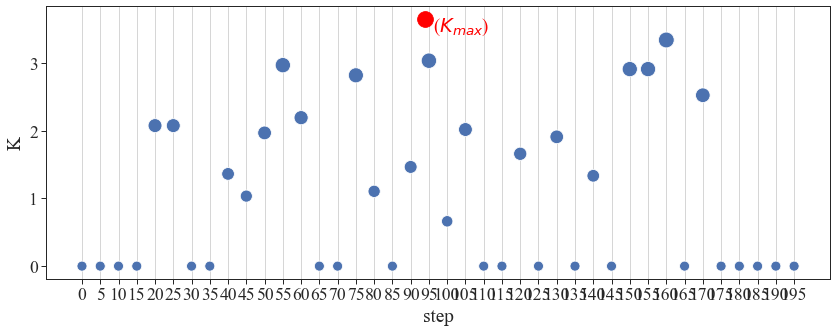

In [9]:
fig = plt.figure(figsize=(12, 5))
nsteps = 5
sns.scatterplot(x='step',y='K',data=df[::nsteps],size='K',legend=False,sizes=(100,250))
plt.scatter([steps[np.argmax(Kvalues)]],[Kvalues.max()],marker='o',s=250,c='red')
plt.text(x=steps[np.argmax(Kvalues)]+2,y=0.95*Kvalues.max(),s=r'($K_{max}$)',c='red')
plt.xlabel('step')
plt.ylabel('K')
plt.xticks(df['step'][::nsteps])
# plt.xlim(170,200)
plt.grid(axis='x') 
plt.tight_layout()
plt.savefig('toyWalk_Kvalues.pdf')
plt.show()

In [10]:
for p in modelList[85:105]:
    if not p.K: continue
#     if len(p.unFrozenParticles()) != 2: continue
#     if not 100006 in p.masses.keys(): continue
#     if abs(p.masses[100006]-1100) > 100: continue
    print(p,p.step)
#     print('\t',p.masses,'\n')

ProtoModel (XZ1,Xt): K = 2.96, Z = 2.28 86
ProtoModel (XZ1,Xt,Xnue): K = 1.96, Z = 2.28 88
ProtoModel (XZ1,Xt,XZ2): K = 1.46, Z = 2.28 90
ProtoModel (XZ1,Xt,XW): K = 1.66, Z = 2.28 91
ProtoModel (XZ1,Xt,Xmu): K = 1.96, Z = 2.28 92
ProtoModel (XZ1,Xt): K = 2.96, Z = 2.28 93
ProtoModel (XZ1,Xt): K = 3.65, Z = 2.43 94
ProtoModel (XZ1,Xt): K = 3.03, Z = 2.30 95
ProtoModel (XZ1,Xt,Xe): K = 2.03, Z = 2.30 96
ProtoModel (XZ1,Xt,XW): K = 1.76, Z = 2.30 98
ProtoModel (XZ1,Xt,Xg): K = 0.66, Z = 2.27 100
ProtoModel (XZ1,Xt,Xmu): K = 2.03, Z = 2.30 101
ProtoModel (XZ1,Xt,XW): K = 1.73, Z = 2.30 102
ProtoModel (XZ1,Xt,Xb): K = 1.52, Z = 2.36 103
ProtoModel (XZ1,Xt): K = -1.48, Z = 0.88 104


In [11]:
printSteps = [93,94,96]
muvals = np.linspace(-10,10,500)
llhDictList = []
for stp in printSteps:
    protomodel = [p for p in modelList if p.step == stp][0]
    print(protomodel,protomodel.masses)
    kold = protomodel.K
    getPredictions(protomodel,'../toyWalk/toy-database')
    knew = protomodel.K
    if kold != knew and abs(kold-knew) > 0.1:
        print(protomodel,protomodel.step,'kold=',kold,'knew=',knew)
        break
    llhDict = getLikelihoods(protomodel,muvals)
    llhDictList.append(llhDict)

ProtoModel (XZ1,Xt): K = 2.96, Z = 2.28 {1000022: 162.98433665715285, 1000006: 1047.0637937369445}
[combine:0] selected predictions down via SRs from 6 to 3.
[combine:0] sorting out subsets, reduced 2 -> 2 combinations.
ProtoModel (XZ1,Xt): K = 3.65, Z = 2.43 {1000022: 162.98433665715285, 1000006: 1118.1114203508687}
[combine:0] selected predictions down via SRs from 6 to 3.
[combine:0] sorting out subsets, reduced 2 -> 2 combinations.
ProtoModel (XZ1,Xt,Xe): K = 2.03, Z = 2.30 {1000022: 374.9086787282855, 1000006: 1118.1114203508687, 1000011: 2266.998269370114}
[combine:0] selected predictions down via SRs from 6 to 3.
[combine:0] sorting out subsets, reduced 2 -> 2 combinations.


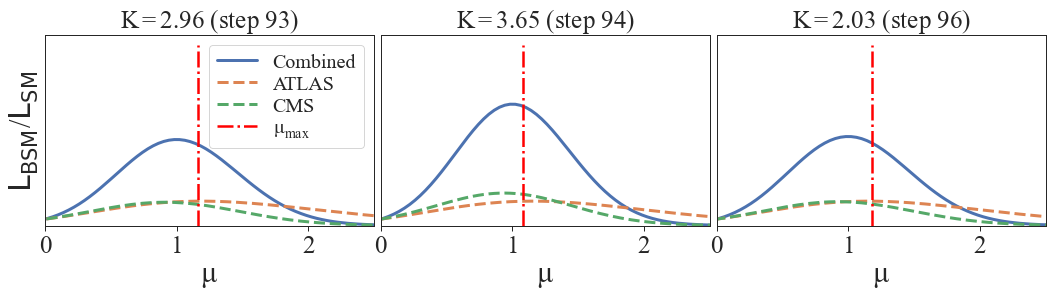

In [12]:
f, axarr = plt.subplots(int(len(printSteps)/3), 3,figsize=(15, 4.5),sharey=True)
irow, icolumn = 0,0
for i,stp in enumerate(printSteps):
    ax = axarr[icolumn]
    protomodel = [p for p in modelList if p.step == stp][0]
    llhDict = llhDictList[i]
    for key,val in llhDict.items():
        if key == 'SM values': continue
        if key == 'Critic': continue
        if key == 'Combined': ls = '-'
        else: ls = '--'
        ax.plot(muvals,val/llhDict['SM values'][key],label=key.split('-')[0],linestyle=ls,linewidth=3)
    
    ax.axvline(x=protomodel.mumax,ymax=0.95,c='red',linestyle='-.',label=r'$\mathdefault{\mu_{max}}$',
                   linewidth=2.5)
    tit = r'$'
    tit += '\mathdefault{K = %1.2f}$ (step %i)' %(protomodel.K,protomodel.step)
    ax.set_title(tit,fontsize=25)
    ax.set_xticks(np.linspace(0,5,6))
    icolumn += 1
    ax.set_xlabel(r'$\mathdefault{\mu}$',fontsize=30)
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    if icolumn == 1:
        ax.set_ylabel(r'$\mathdefault{\mathrm{L}_{\mathrm{BSM}}/\mathrm{L}_{\mathrm{SM}}}$',fontsize=30)
        ax.legend(loc='upper right',framealpha=1,fontsize=20,labelspacing=0.2)
    else:
        ax.set_yticks([])
    ax.set_xlim(0,2.5)
    ax.set_ylim(0,30)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.02)
plt.savefig('toyWalk_likelihoods.pdf')
plt.show()

In [13]:
for stp in printSteps:
    protomodel = [p for p in modelList if p.step == stp][0]
    print(protomodel,'step=',protomodel.step,'muhat=',protomodel.muhat)
    print('---------')
    print('masses:')    
    for key,val in protomodel.masses.items():
        print(key,val)
    print('---------')
    print('ssms:')    
    for key,val in protomodel.ssmultipliers.items():
        print(key,val)
    print('\n')

ProtoModel (XZ1,Xt): K = 2.96, Z = 2.28 step= 93 muhat= 1.0001521940311162
---------
masses:
1000022 162.98433665715285
1000006 1047.0637937369445
---------
ssms:
(1000022, 1000022) 0.5165044200228553
(1000006, 1000006) 0.5779392119584355
(-1000006, 1000006) 0.6623039618469031
(-1000006, -1000006) 0.5779392119584355
(1000006, 1000022) 0.5779392119584355
(-1000006, 1000022) 1.0


ProtoModel (XZ1,Xt): K = 3.65, Z = 2.43 step= 94 muhat= 0.9999998371616852
---------
masses:
1000022 162.98433665715285
1000006 1118.1114203508687
---------
ssms:
(1000022, 1000022) 0.7542093975315138
(1000006, 1000006) 0.8439176277363153
(-1000006, 1000006) 0.9663464334751035
(-1000006, -1000006) 0.8439176277363153
(1000006, 1000022) 0.8439176277363153
(-1000006, 1000022) 1.460218670535559


ProtoModel (XZ1,Xt,Xe): K = 2.03, Z = 2.30 step= 96 muhat= 1.0000001130298188
---------
masses:
1000022 374.9086787282855
1000006 1118.1114203508687
1000011 2266.998269370114
---------
ssms:
(1000022, 1000022) 0.6996747995